# Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from statsmodels.sandbox.stats.runs import runstest_1samp
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import acf

import os
import re
from scipy import ndimage
import math
import random
import cv2
import skimage
from scipy import stats
import pylab

from PIL import Image, ImageEnhance
from skimage.measure import label, regionprops
from skimage.io import imsave

In [2]:
# Loading a CSV file into a DataFrame
df = pd.read_csv('../Processed dataset/df.csv')
df_new = pd.read_csv('../Processed dataset/df_new.csv')

df_voids = pd.read_csv('../Processed dataset/df_voids.csv')
df_parts = pd.read_csv('../Processed dataset/df_parts.csv')
df_new_voids = pd.read_csv('../Processed dataset/df_new_voids.csv')
df_new_parts = pd.read_csv('../Processed dataset/df_new_parts.csv')

## Cols comparison

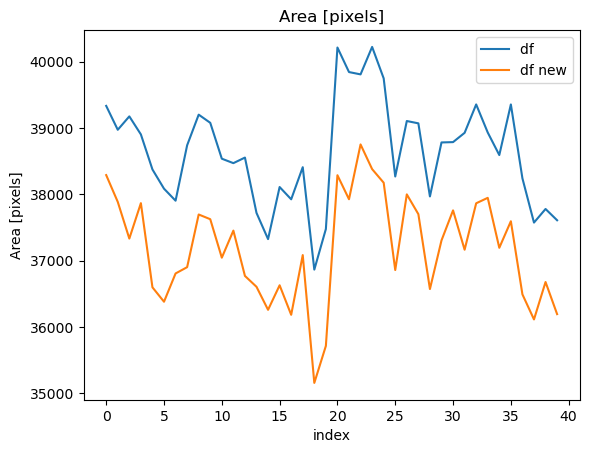

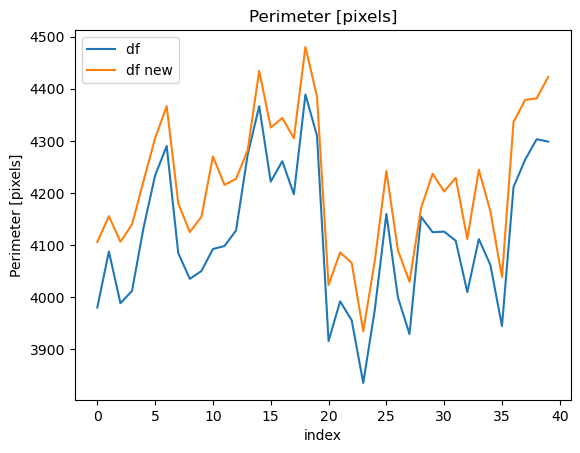

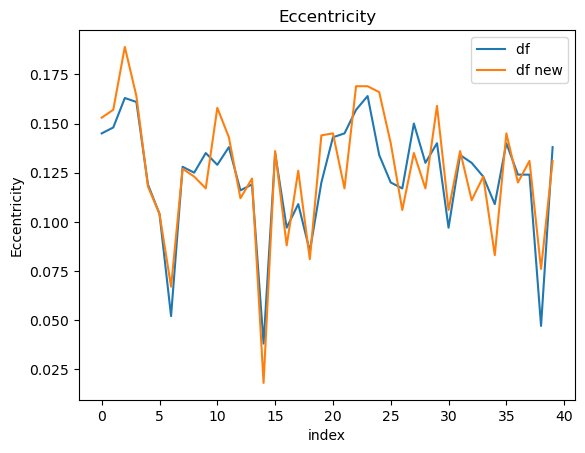

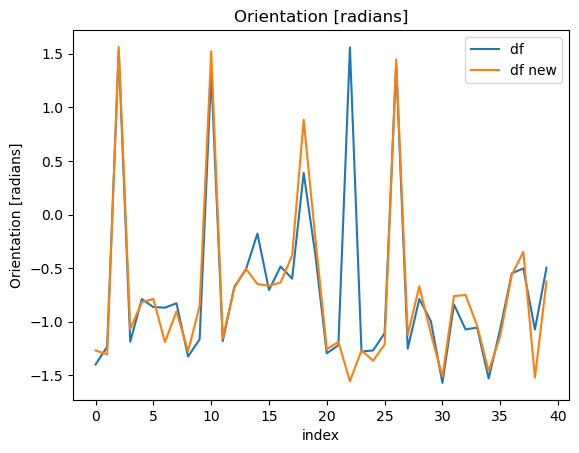

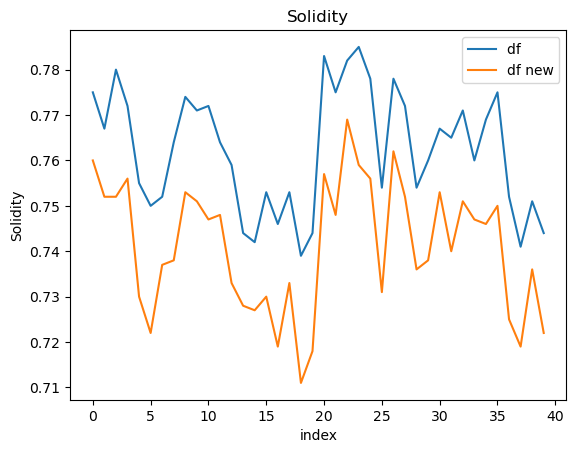

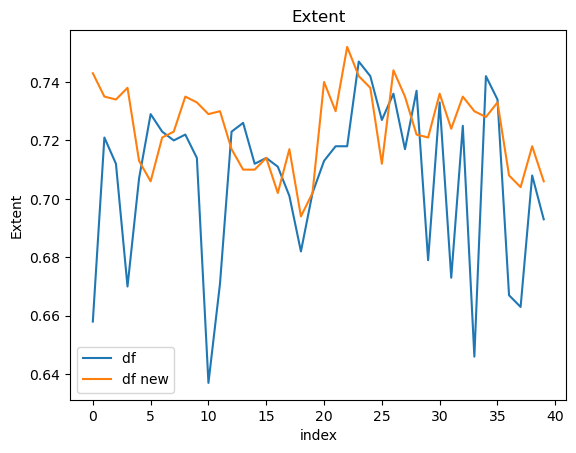

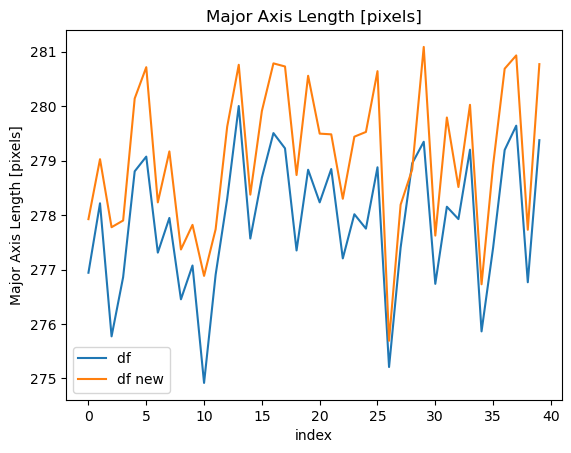

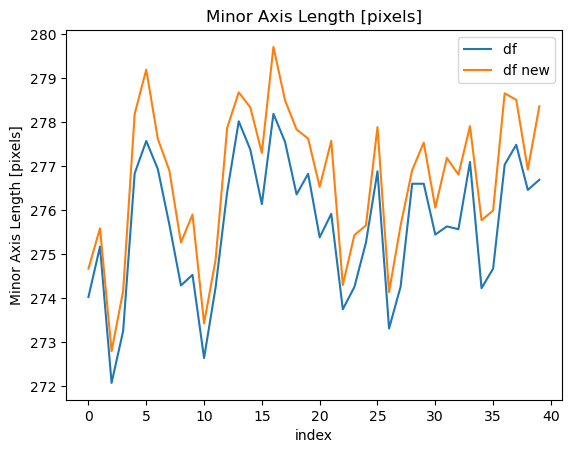

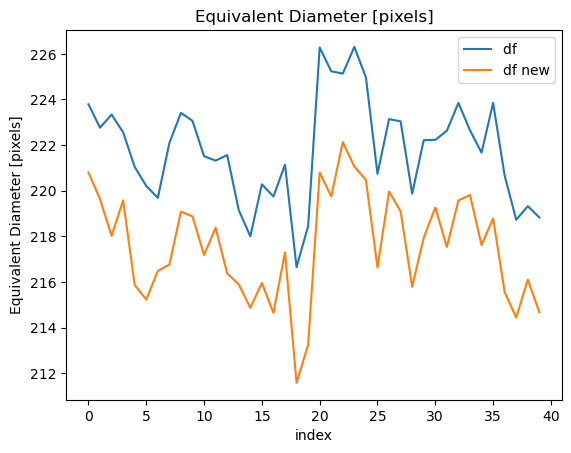

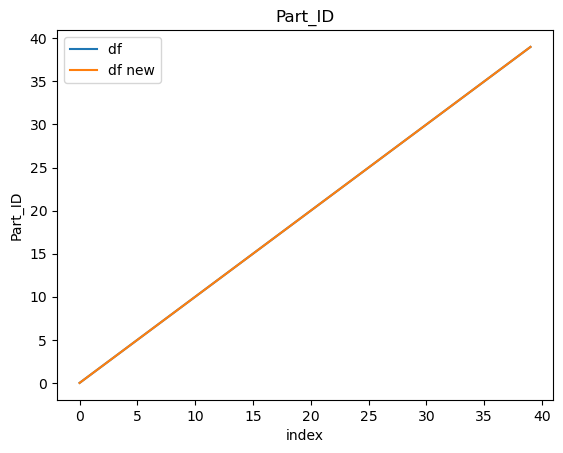

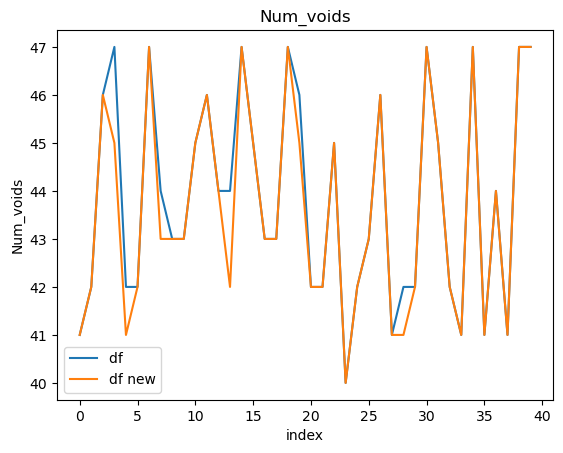

In [3]:
for column in df_parts.columns[4:]:
    # Traccia la colonna corrente di df rispetto alla corrispondente colonna di df_new
    plt.plot(df_parts[column], label='df ')
    plt.plot(df_new_parts[column], label='df new')
    # Aggiungi titolo, etichette degli assi e legenda
    plt.title(column)
    plt.xlabel('index')
    plt.ylabel(column)
    plt.legend()

    # Mostra il grafico per questa coppia di colonne
    plt.show()
    
# if we do this plot on df and df_new (rather than df_parts and df_new_parts)
# we clearly see different patterns, so makes sense to divide parts from voids

## Normality

Colonna: Area [pixels]
P-value di normalità per df_parts: 0.9523186683654785 - normality (alpha 5%)? True
P-value di normalità per df_new_parts: 0.7310476303100586 - normality (alpha 5%)? True

Colonna: Perimeter [pixels]
P-value di normalità per df_parts: 0.6340415477752686 - normality (alpha 5%)? True
P-value di normalità per df_new_parts: 0.8690754771232605 - normality (alpha 5%)? True

Colonna: Eccentricity
P-value di normalità per df_parts: 0.0004302806337364018 - normality (alpha 5%)? False
P-value di normalità per df_new_parts: 0.09720978140830994 - normality (alpha 5%)? True

Colonna: Orientation [radians]
P-value di normalità per df_parts: 1.2606984682861366e-06 - normality (alpha 5%)? False
P-value di normalità per df_new_parts: 9.760273087522364e-07 - normality (alpha 5%)? False

Colonna: Solidity
P-value di normalità per df_parts: 0.09568046033382416 - normality (alpha 5%)? True
P-value di normalità per df_new_parts: 0.26717373728752136 - normality (alpha 5%)? True

Colonna

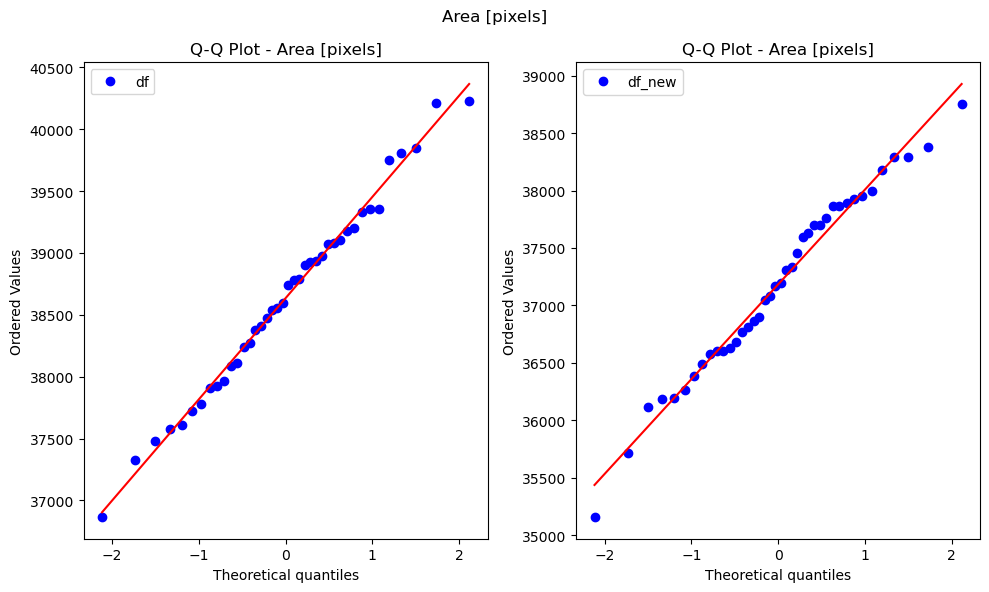

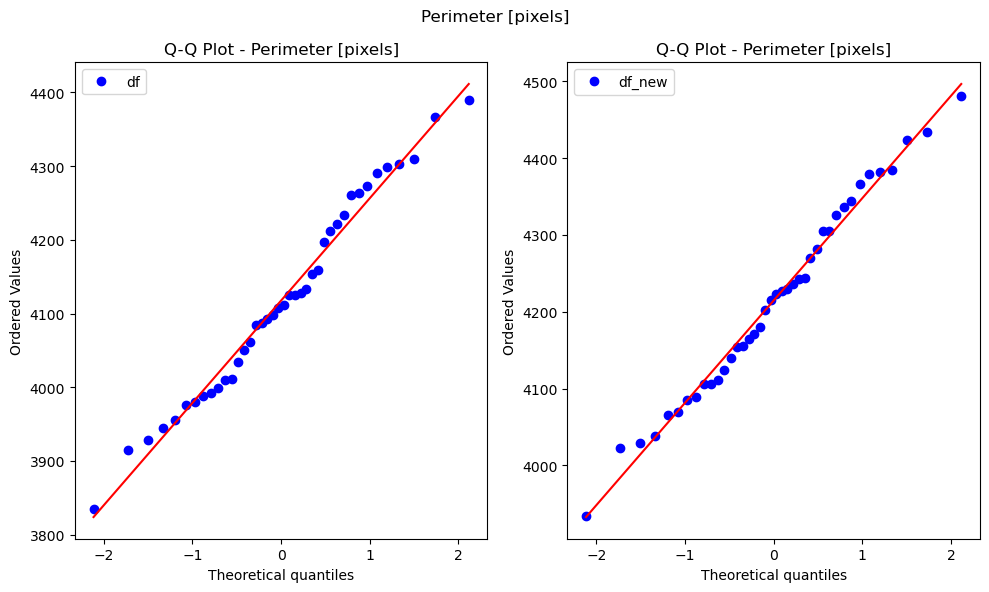

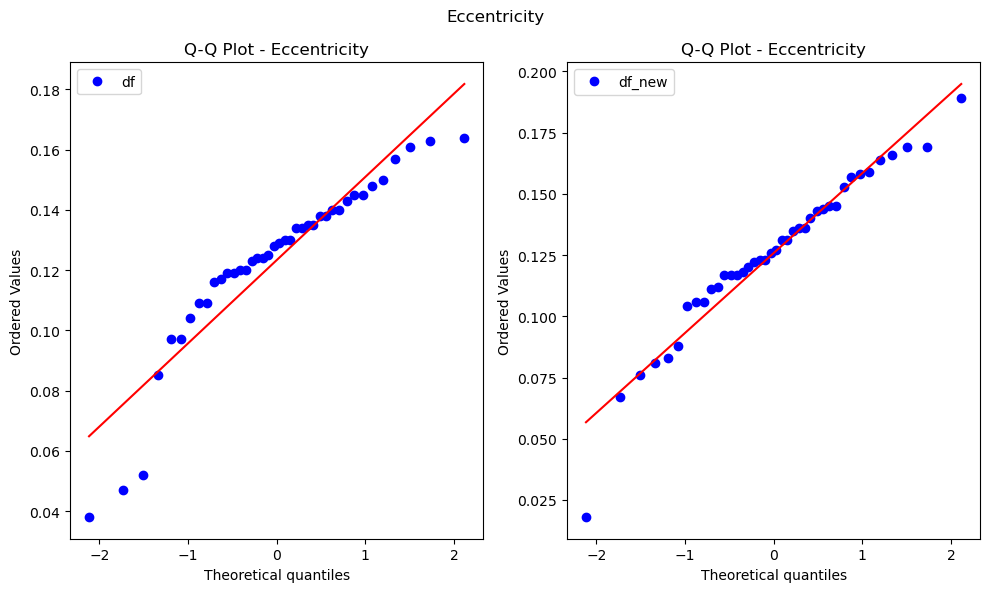

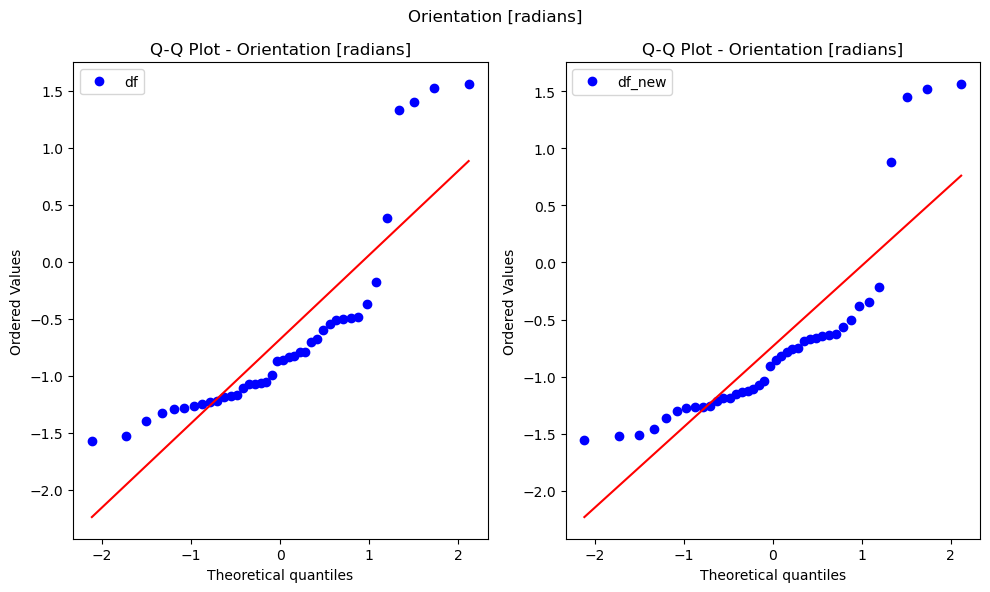

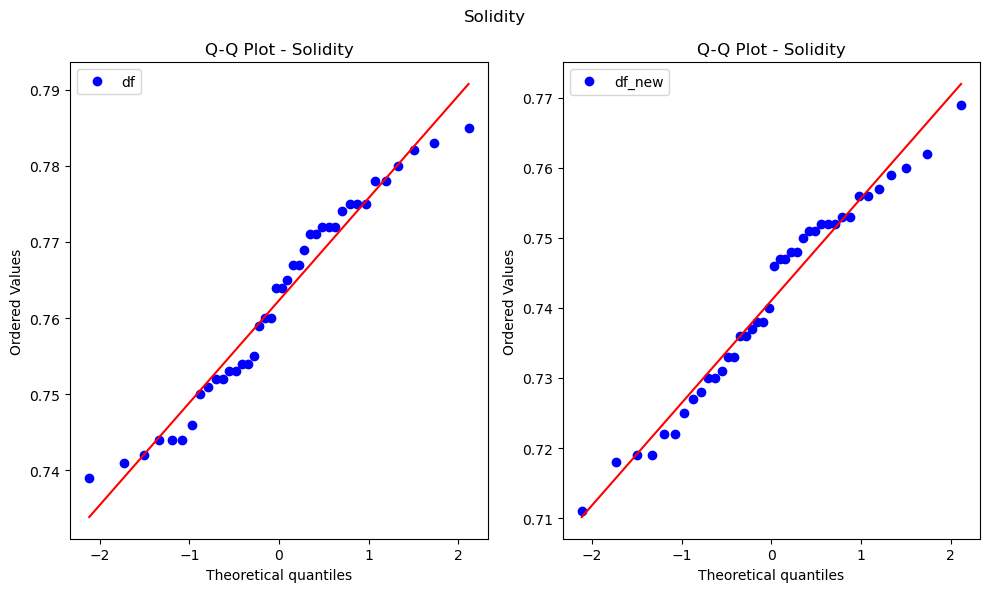

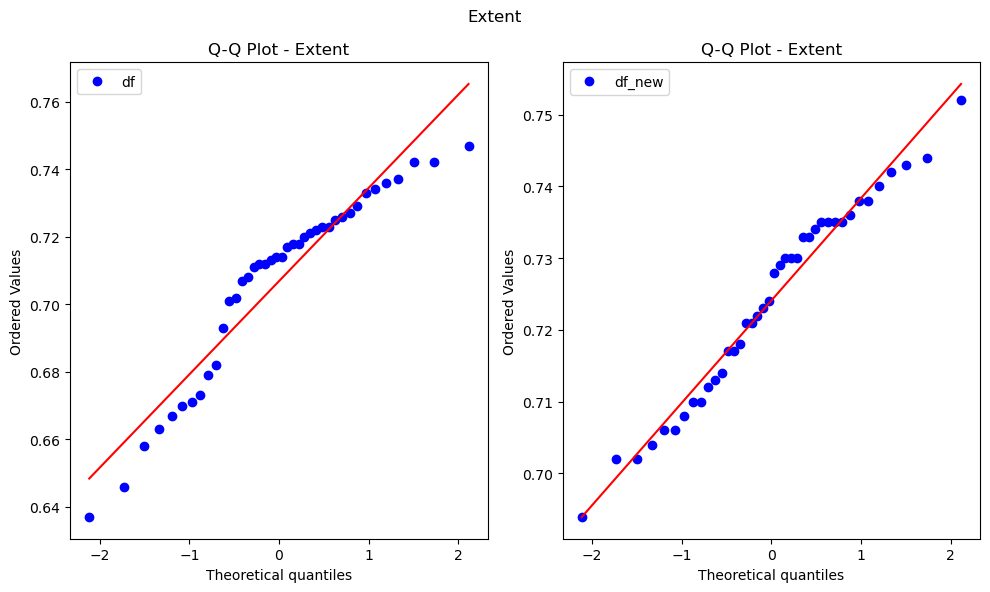

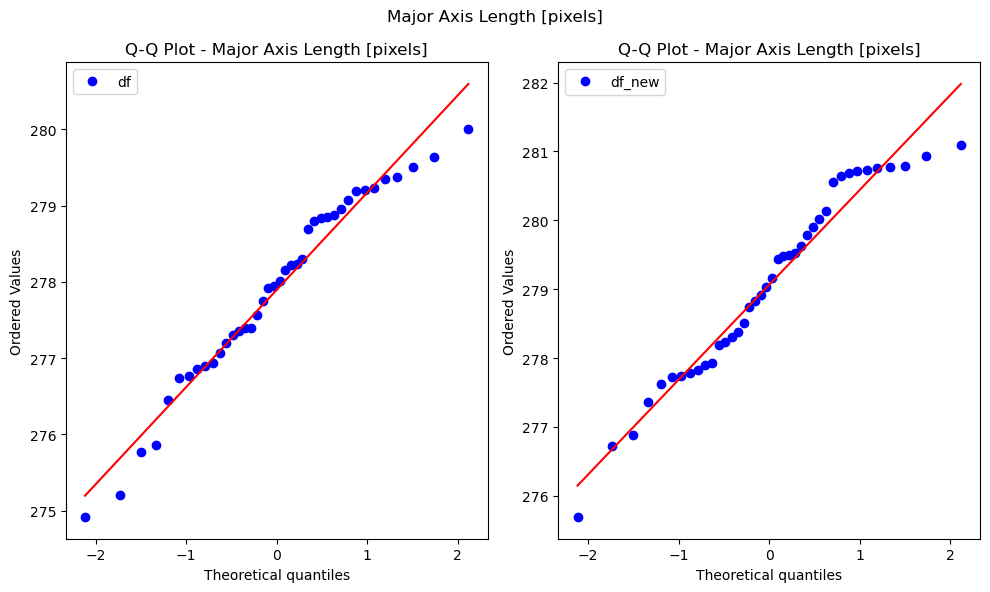

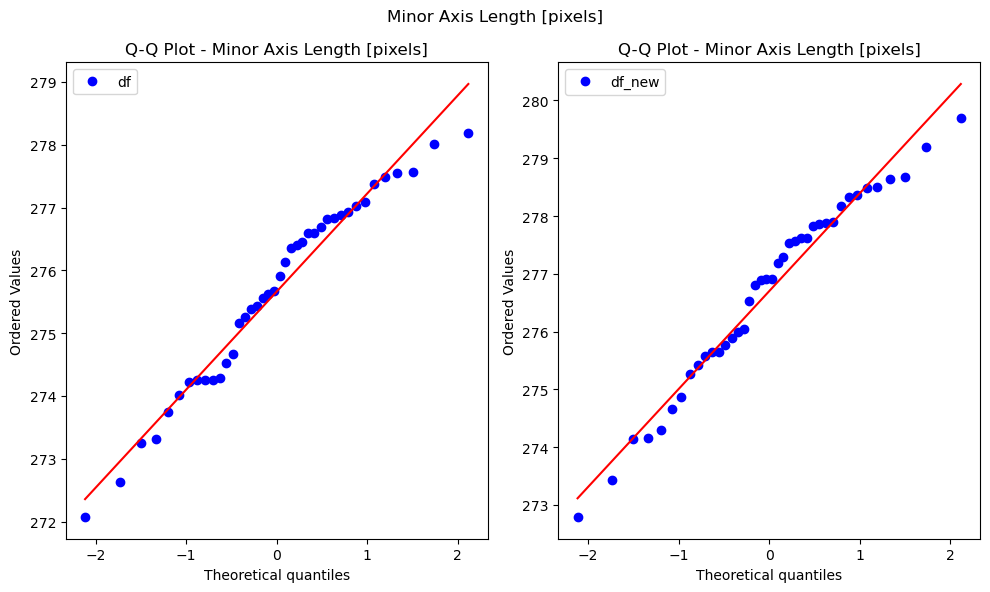

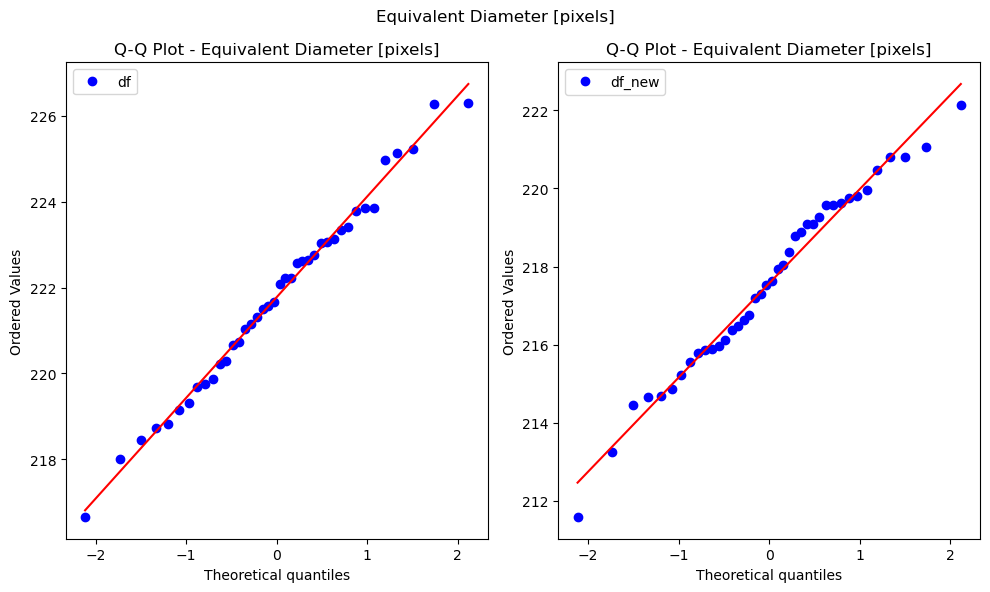

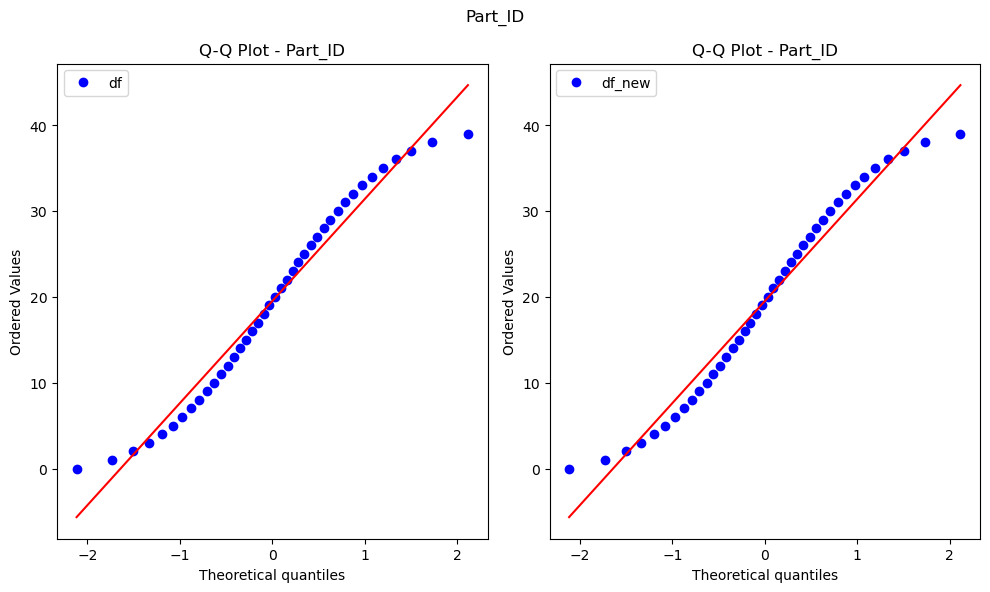

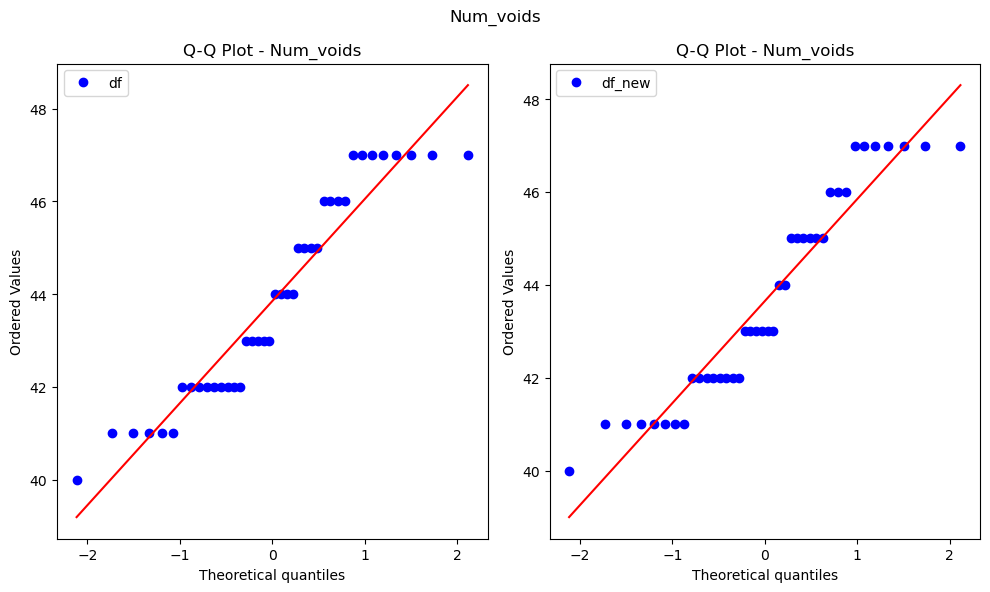

In [5]:
for i, column in enumerate(df_parts.columns[4:]):
	plt.figure(figsize=(10, 6))
	plt.subplot(1, 2, 1)
	stats.probplot(df_parts[column], dist="norm", plot=plt)
	plt.legend(['df'])
	plt.title(f"Q-Q Plot - {column}")
	# plt.title(f"Q-Q Plot")

	plt.subplot(1, 2, 2)
	stats.probplot(df_new_parts[column], dist="norm", plot=plt)
	plt.legend(['df_new'])
	plt.title(f"Q-Q Plot - {column}")
	# plt.title(f"Q-Q Plot")

	plt.suptitle(column)
	plt.tight_layout()
     
for column in df_parts.columns[4:]:
    # Calcola il p-value di normalità per la colonna corrente di df_parts
    shapiro_stat, shapiro_pvalue_parts = stats.shapiro(df_parts[column])
    
    # Calcola il p-value di normalità per la colonna corrente di df_new_parts
    shapiro_stat, shapiro_pvalue_new_parts = stats.shapiro(df_new_parts[column])
   
    # Stampa i risultati
    print(f"Colonna: {column}")
    print(f"P-value di normalità per df_parts: {shapiro_pvalue_parts} - normality (alpha 5%)? {shapiro_pvalue_parts>0.05}")
    print(f"P-value di normalità per df_new_parts: {shapiro_pvalue_new_parts} - normality (alpha 5%)? {shapiro_pvalue_new_parts>0.05}\n")

## Boxplots and hists

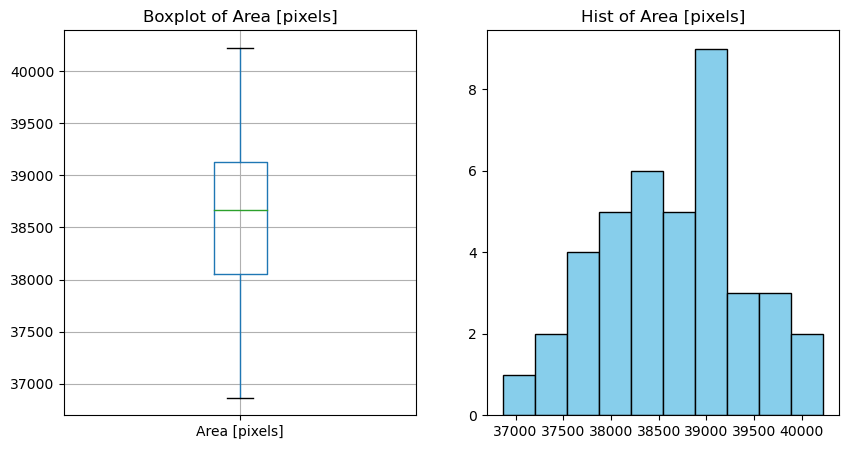

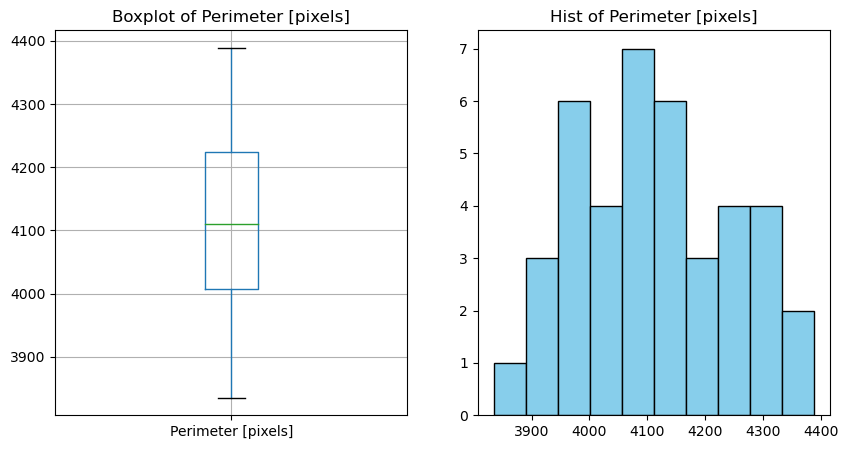

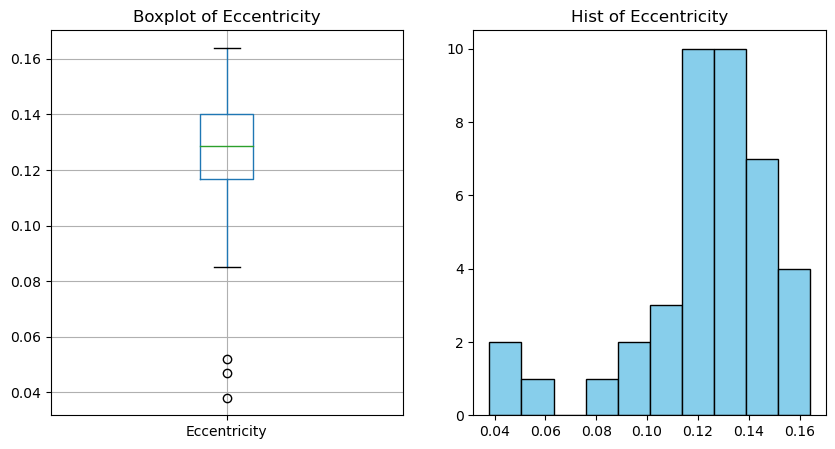

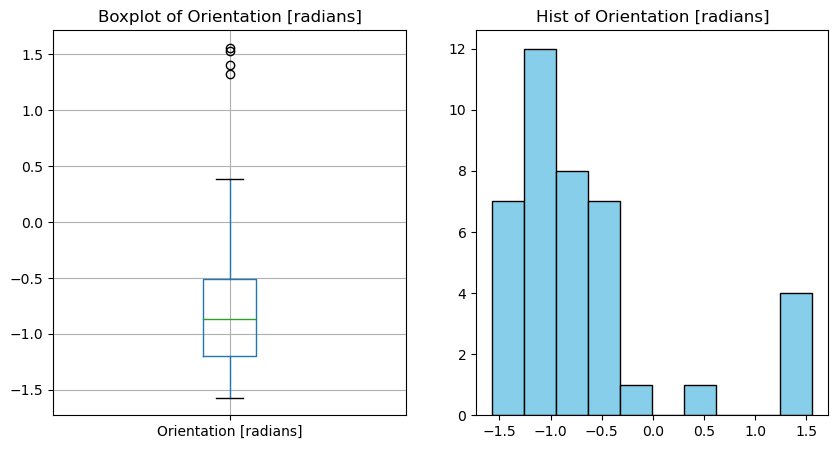

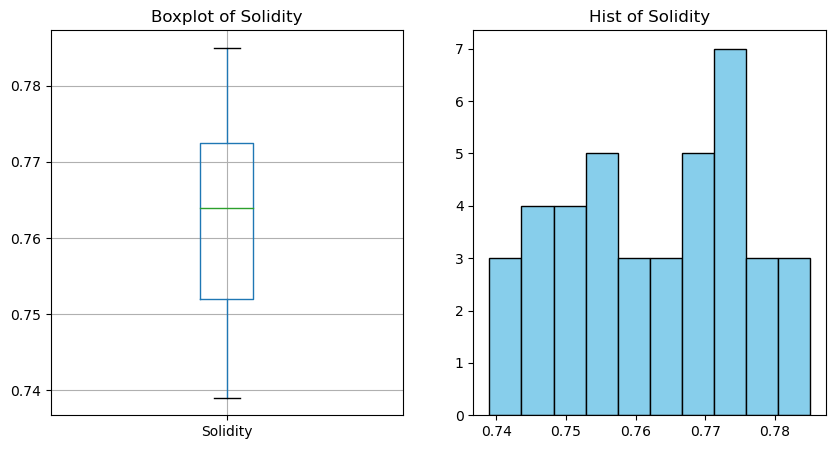

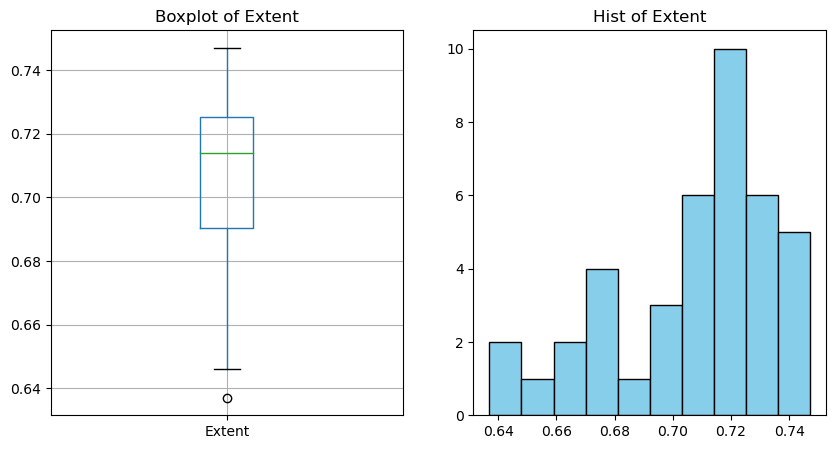

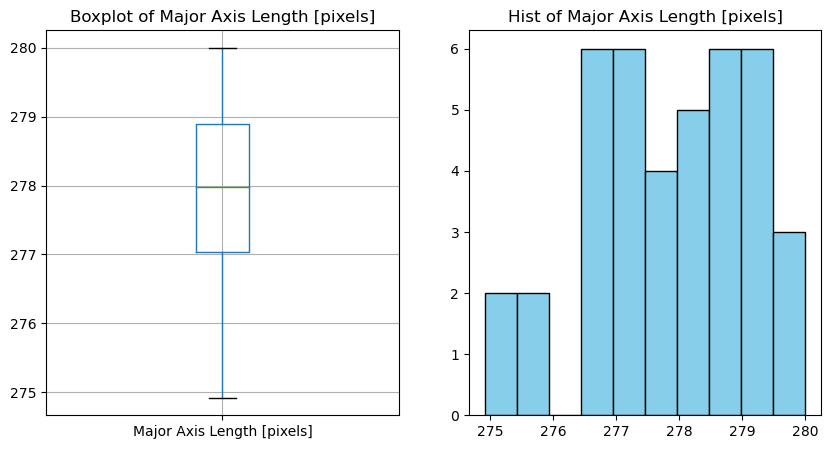

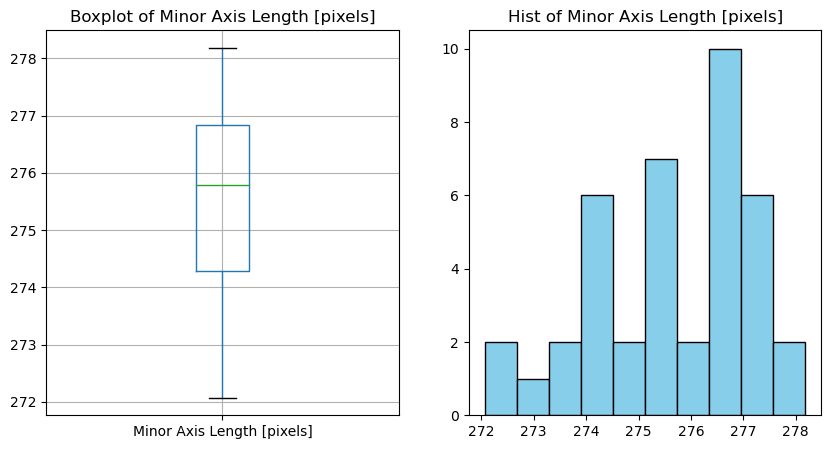

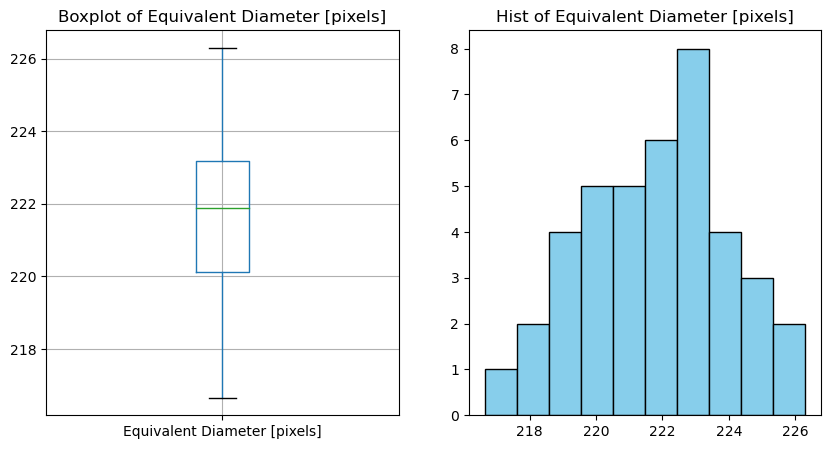

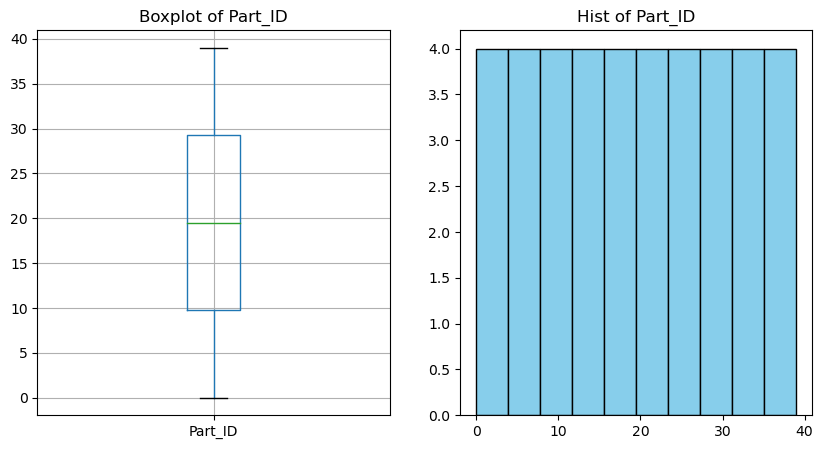

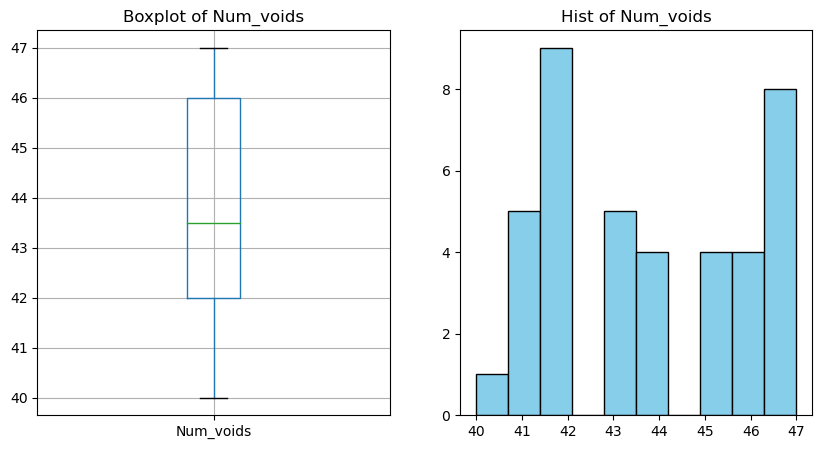

In [17]:
for column in df_parts.columns[4:]:
	plt.figure(figsize=(10,5))
	plt.subplot(1,2,1)
	df_parts.boxplot(column)
	plt.title(f'Boxplot of {column}')

	plt.subplot(1,2,2)
	plt.hist(df_parts[column], bins=10, color='skyblue', edgecolor='black')
	plt.title(f'Hist of {column}')
	plt.show()

## Each image focus

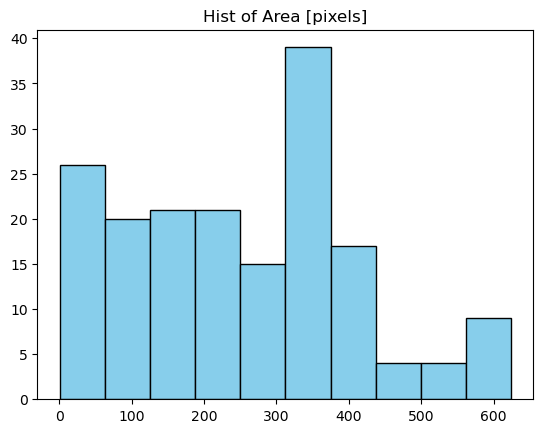

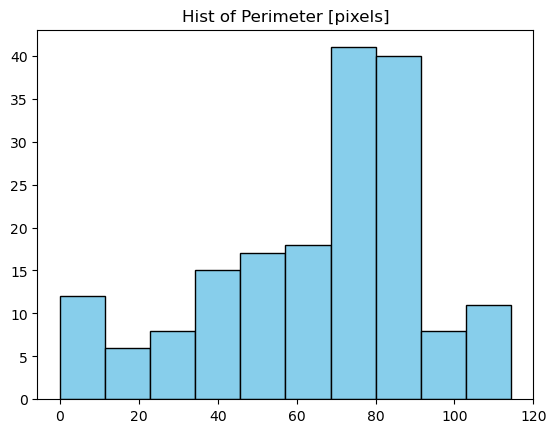

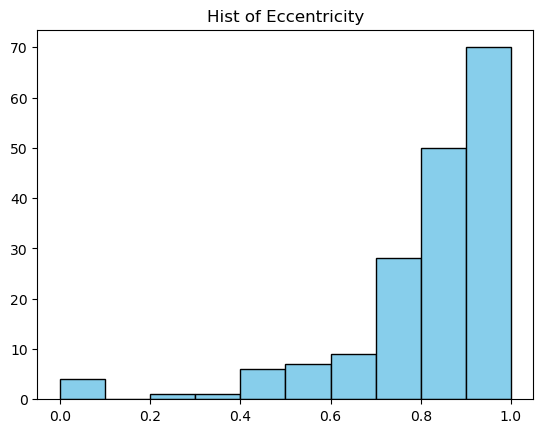

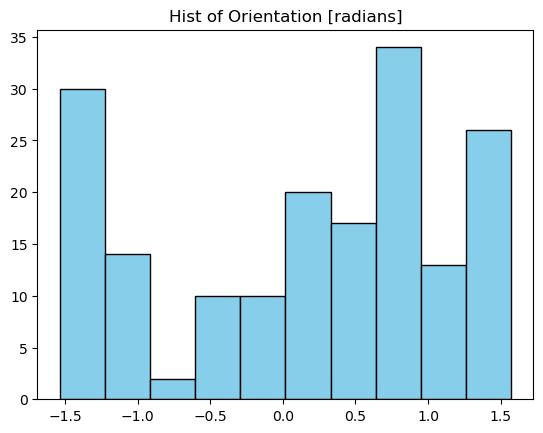

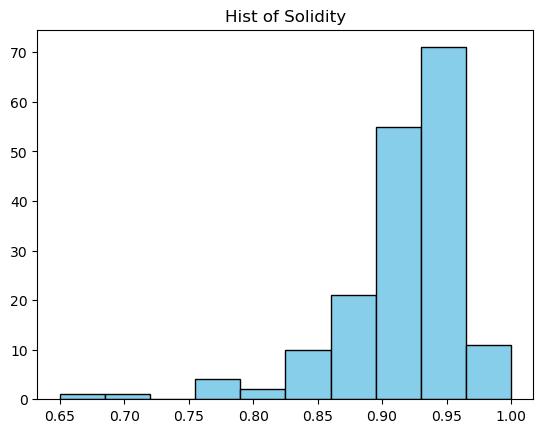

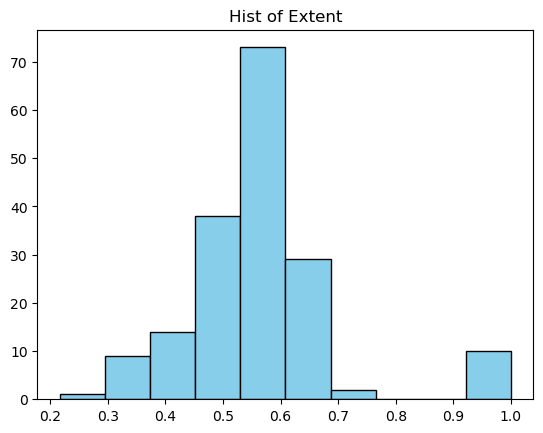

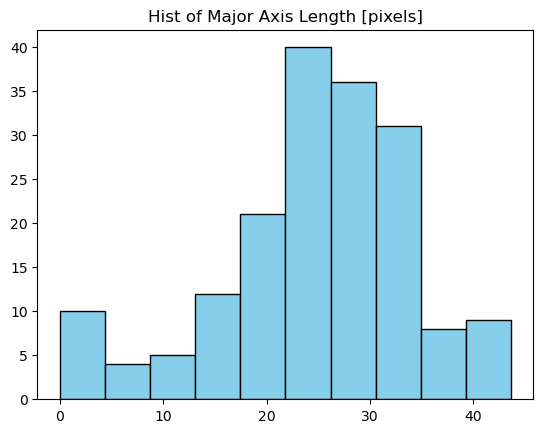

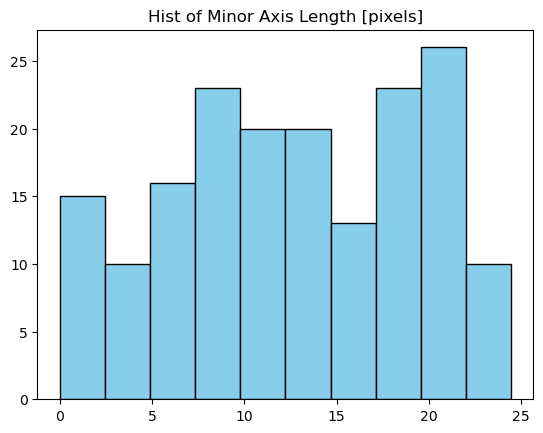

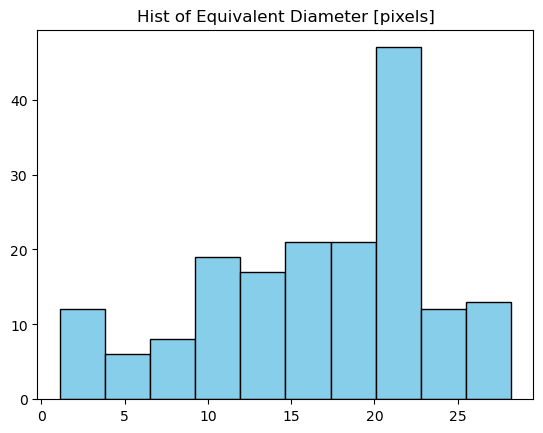

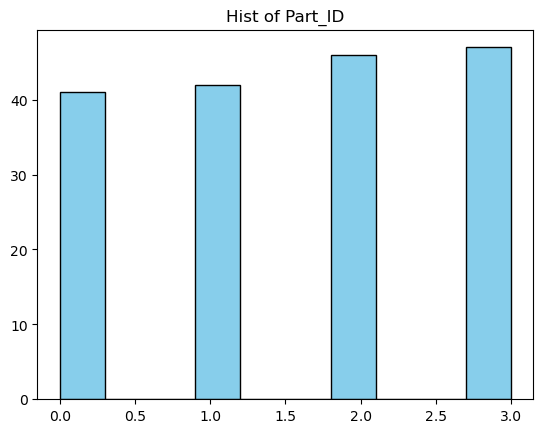

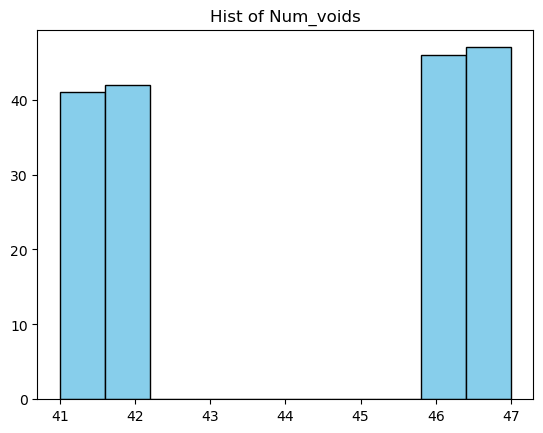

In [21]:
img01_df = df_voids.loc[df_voids['Image name'] == 'img01.bmp', df_voids.columns[4:]]
# Seleziona solo le righe con 'Image name' uguale a 'img01.bmp'

# Itera sulle colonne di questo sotto-dataframe
for col in img01_df.columns.tolist():
	plt.hist(img01_df[col], bins=10, color='skyblue', edgecolor='black')
	plt.title(f'Hist of {col}')
	plt.show()

Some notes:  
- which is the scope?  
- can we create new variables?  
-  adding image analysis  
- the eccentricity --> log(-eccentricity) ( for normality)  
- remove outliers/ interpret them


## Old code

In [22]:
# Anderson-Darling test ???? SOME PROBLEMS

def ADpvalue(data):
	"""
	This function computes the p-value of the Anderson-Darling test.
	
	Input:
		data: data to be tested
	Output:
		p_value_AD: p-value of the Anderson-Darling test
	"""
	anderson = stats.anderson(data, dist='norm')
	# compute the p-value of the Anderson-Darling test
	if anderson.statistic >= 0.6:
		p_value_AD = np.exp(1.2937 - 5.709*anderson.statistic + 0.0186*(anderson.statistic**2))
	elif anderson.statistic >= 0.34:
		p_value_AD = np.exp(0.9177 - 4.279*anderson.statistic - 1.38*(anderson.statistic**2))
	elif anderson.statistic >= 0.2:
		p_value_AD = 1 - np.exp(-8.318 + 42.796*anderson.statistic - 59.938*(anderson.statistic**2))
	else:
		p_value_AD = 1 - np.exp(-13.436 + 101.14*anderson.statistic - 223.73*(anderson.statistic**2))

	return p_value_AD

# Example usage with a DataFrame 'dataNum'
# Assuming 'dataNum' is your DataFrame containing numerical data
# Assuming each column in 'dataNum' represents a variable you want to test

dataNum = df.select_dtypes(include=np.number)
for col in dataNum.columns.tolist():  
	p_value_AD = ADpvalue(dataNum[col])
	print(f'p-value of the Anderson-Darling test for {col}: {p_value_AD:.3f}')


p-value of the Anderson-Darling test for ID: 0.000
p-value of the Anderson-Darling test for Area [pixels]: inf
p-value of the Anderson-Darling test for Perimeter [pixels]: inf
p-value of the Anderson-Darling test for Eccentricity: 0.000
p-value of the Anderson-Darling test for Orientation [radians]: 0.000
p-value of the Anderson-Darling test for Solidity: 0.000
p-value of the Anderson-Darling test for Extent: 0.000
p-value of the Anderson-Darling test for Major Axis Length [pixels]: 1511030393770227162003779399905844333357419357264268208936458972611295710864454567262998905429485439856992987283169820189994024308959741793337201646307926041823825486650119331757704464815929662145550627110912.000
p-value of the Anderson-Darling test for Minor Axis Length [pixels]: inf
p-value of the Anderson-Darling test for Equivalent Diameter [pixels]: 19315448332851835944334324422462959672560793981042361528673147246919530470579697039170133220422593838138142737771726343084849060416283304997276745743537487

c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


Since for the scipy.special.boxcox transformation all variables must be positive, I apply a linear transformation to all the dataset --> dataset.pos = datset + pi/2+0.001.  
Rotate pi/2 Cartesian axis ( see slides REGION PROPERTIES - ORIENTATION)

Note that i chose to use this thpe of trasformation becuause the majority of the problem are related to the orientation column, in this way we obtain all positive values.

In [23]:
import math

dataNumTrasf = pd.DataFrame()  # Initialize an empty DataFrame to store transformed data

# Assuming dataNum is your DataFrame containing numerical data
dataNumTrasf = dataNum.iloc[:, 1:] + math.pi/2 + 0.001 # remove ID column

In [24]:

# Box-Cox transformation

data_norm = pd.DataFrame() 

for col in dataNumTrasf.columns.tolist():
	data_norm[col], lmbda = stats.boxcox(dataNumTrasf[col])
	print(f'Lambda for {col} = {lmbda:.3f}')


Lambda for Area [pixels] = -0.012
Lambda for Perimeter [pixels] = -0.019
Lambda for Eccentricity = 10.371
Lambda for Orientation [radians] = 0.774
Lambda for Solidity = 24.228
Lambda for Extent = -1.098
Lambda for Major Axis Length [pixels] = 0.059
Lambda for Minor Axis Length [pixels] = -0.087
Lambda for Equivalent Diameter [pixels] = -0.095
Lambda for Part_ID = 0.717
Lambda for Num_voids = -0.523


In [25]:
for col in data_norm.columns.tolist():
  # Shapiro-Wilk test
  _, p_value_SW = stats.shapiro(data_norm[col])
  print('p-value of the Shapiro-Wilk ', col, ' test: %.3f' % p_value_SW)

p-value of the Shapiro-Wilk  Area [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Perimeter [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Eccentricity  test: 0.000
p-value of the Shapiro-Wilk  Orientation [radians]  test: 0.000
p-value of the Shapiro-Wilk  Solidity  test: 0.000
p-value of the Shapiro-Wilk  Extent  test: 0.000
p-value of the Shapiro-Wilk  Major Axis Length [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Minor Axis Length [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Equivalent Diameter [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Part_ID  test: 0.000
p-value of the Shapiro-Wilk  Num_voids  test: 0.000


The box cox trasformation does not solve the pb of guassian distrution -> we can try more values for lambda / outlier analysis

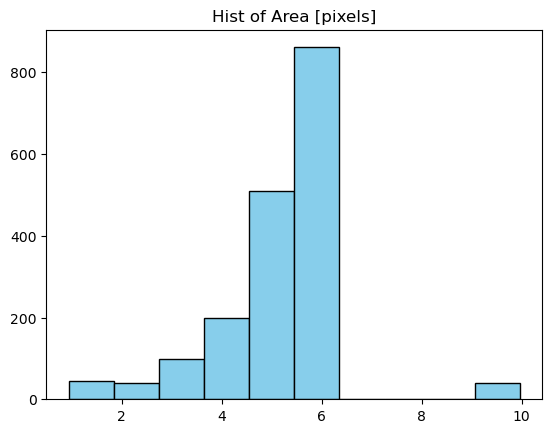

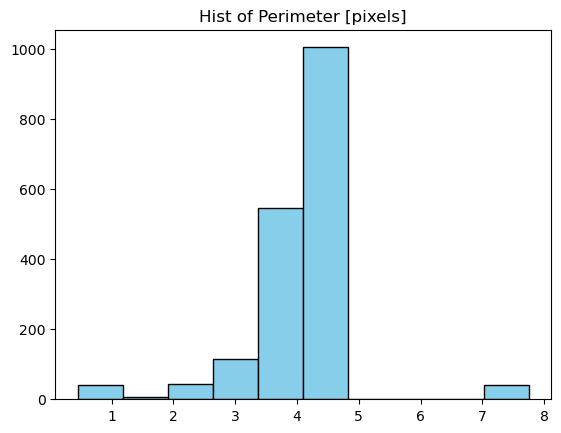

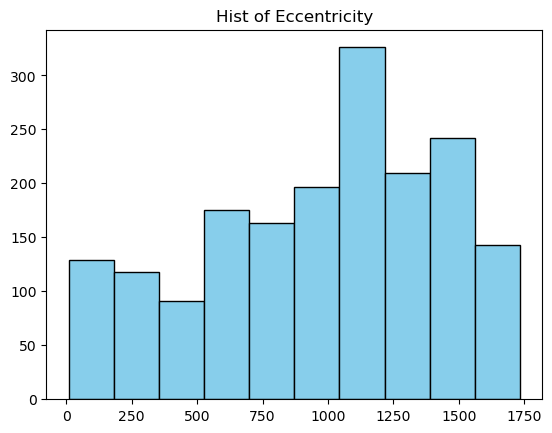

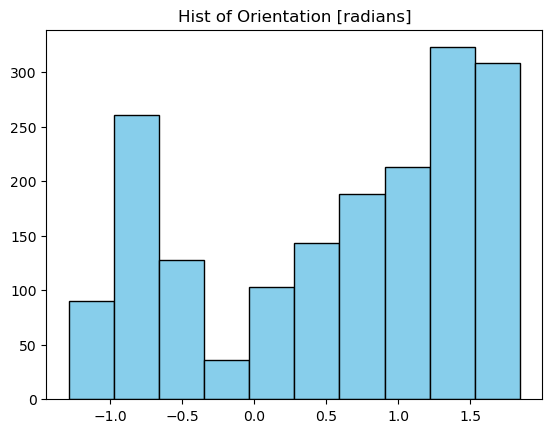

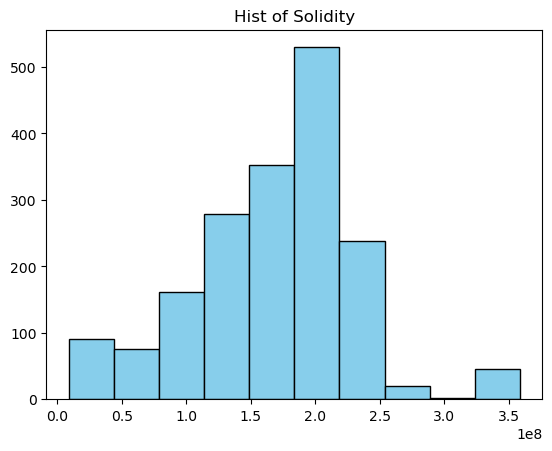

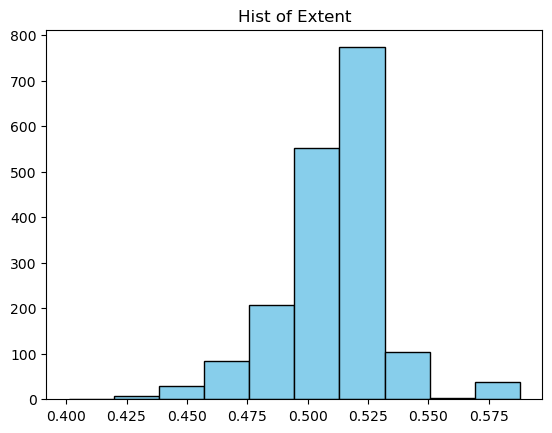

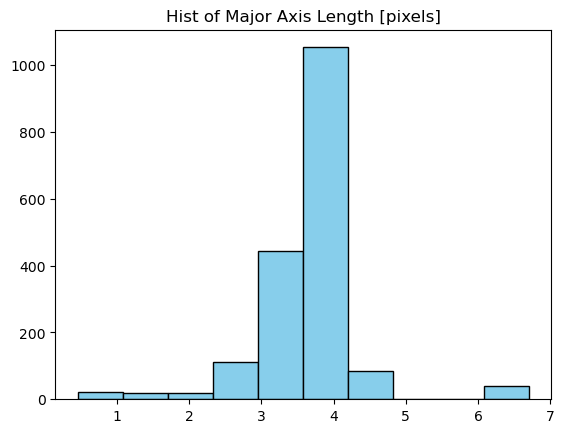

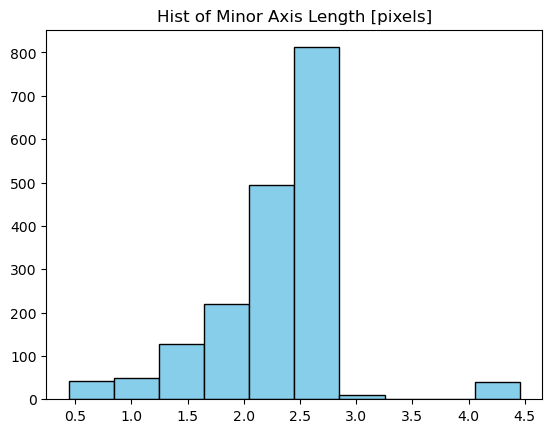

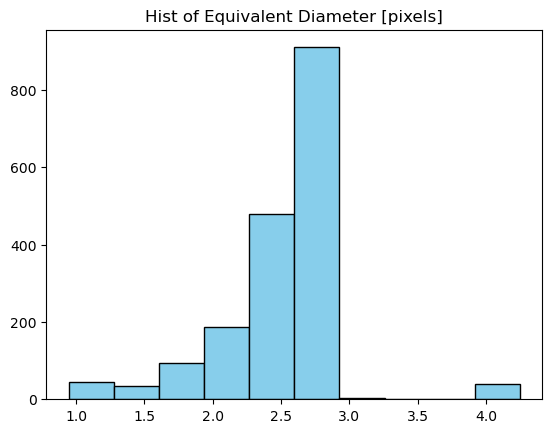

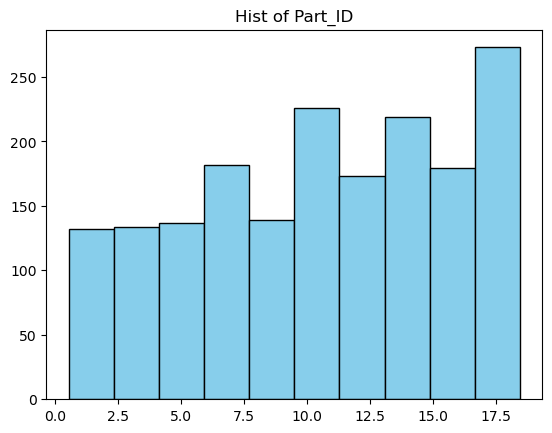

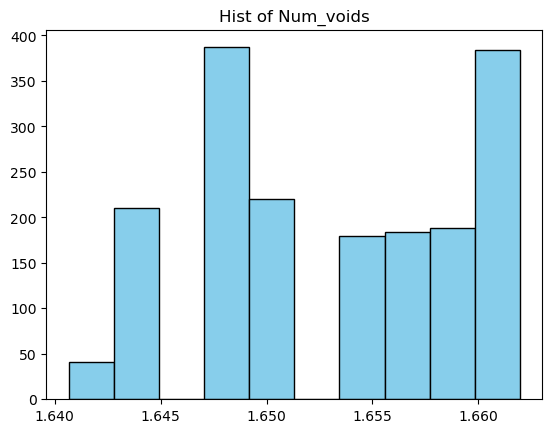

In [26]:
for col in data_norm.columns.tolist():
  # Shapiro-Wilk test
  plt.hist(data_norm[col], bins=10, color='skyblue', edgecolor='black')
  plt.title(f'Hist of {col}')
  plt.show()